# Python自动化报表分析

**说明**
本脚本应当与CSMAR数据库配合，具体使用步骤：
- 下载**某一**公司的全部报表，提取资产负债表、利润表两份excel文件，置于同一文件夹中
- 在下方的脚本块`os.chdir(r'……')`的引号中写入上述excel文件的路径
- 可在`cm='#……'`中输入心仪的主题色（注：颜色不宜太亮/太浅）
- 运行全部代码

**更新计划**

- 1.0
    -   ~~完善y坐标轴取值逻辑~~
    -   自动加入副坐标轴
    -   ~~加入现金流量分析图~~
    -   ~~自动保存图片~~
- 2.0
    -   支持导入面板数据
    -   支持分析行业级数据

## 1.   基础配置

In [53]:
#coding=utf-8
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# 色彩模块
import colorsys

In [54]:
# Matplotlib 设置
plt.rcParams['font.sans-serif'] = ['simhei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['axes.autolimit_mode'] = 'round_numbers'
plt.rcParams['lines.linewidth'] = '3'

### 1.1. 写入个人配置

In [55]:
# 在r后面的引号中写入报表文件所在目录
os.chdir(r'E:\18082\Documents\9 CodeProjects\sheet')

# 写入想要的主题色
cm = '#9cc3e5'

### 1.2.    生成配色方案

In [4]:
def rgb2hsb(rgb):   # 转为 HSB 色值
    rgb = (int(rgb[1:3], 16), int(rgb[3:5], 16), int(rgb[5:], 16))
    hsv = colorsys.rgb_to_hsv(rgb[0] / 255, rgb[1] / 255, rgb[2] / 255)

    return hsv

def hsb2rgb(h, s, b):   # 转回 RGB 色系
    rgb = colorsys.hsv_to_rgb(h, s, b)
    rgb = '#' + hex(int(rgb[0] * 255))[2:] + hex(int(rgb[1] * 255))[2:] + hex(int(rgb[2] * 255))[2:]

    return rgb  # 一个带#号的字符串

def lightcolor(rgb):    # 生成两个浅色
    hsb = rgb2hsb(rgb)

    if hsb[1] > 0.1:
        l2s = 0.1
    else:
        l2s = 0
    l1s = (l2s + hsb[1]) / 2

    if hsb[2] <= 0.99:
        l2b = 0.99
    else:
        l2b = 1
    l1b = (hsb[2] + l2b) / 2

    l1 = hsb2rgb(hsb[0], l1s, l1b)
    l2 = hsb2rgb(hsb[0], l2s, l2b)

    return [l1, l2]

def neighborcolor(rgb): # 生成两个相邻色
    hsb = rgb2hsb(rgb)

    h2 = hsb[1] + (1/3)
    if h2 > 1:
        h2 -= 1
    
    h3 = h2 + (1/3)
    if h3 > 1:
        h3 -= 1
    
    h2 = hsb2rgb(h2, hsb[1], hsb[2])
    h3 = hsb2rgb(h3, hsb[1], hsb[2])

    return [h2, h3]

cm_l1 = lightcolor(cm)[0]   # 生成两个浅色
cm_l2 = lightcolor(cm)[1]

# 两个相邻色
cn1 = neighborcolor(cm)[0]
cn2 = neighborcolor(cm)[1]

gray = '#d8d8d8'
black = '#000000'

## 2.   数据整理

In [56]:
def DataClean(filename):
    df = pd.read_excel(filename, sheet_name='sheet1', header=None)
    df.loc[1, 1] = '会计期间'
    df.columns = df.values.tolist()[1]
    df = df[df['会计期间'].apply(lambda x: x[5:7] == "12")]
    #df = df.set_index('会计期间')
    df = df[df['报表类型'].isin(['A'])].fillna(value=0)
    return df
def zoom(dataset):
    max_number = dataset.max().max()
    min_number = min(dataset.min().min(), 0)
    if max_number >= 1e9:
        dataset = dataset / 1e8   # 单位
        label = '（单位：亿元）'
    else:
        dataset = dataset / 1e4
        label = '（单位：万元）'
    
    return [dataset, label]

In [76]:
BalanceSheet = DataClean('FS_Combas.xlsx')
IncomeSheet = DataClean('FS_Comins.xlsx')
CashFlowSheet = DataClean('FS_Comscfd.xlsx')

TheSheet = pd.merge(BalanceSheet, IncomeSheet, on='会计期间')
TheSheet = pd.merge(TheSheet, CashFlowSheet, on='会计期间')

x = TheSheet.loc[:, '会计期间']
barwidth = 0.4
x_coor = np.arange(6)

e:\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
e:\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


## 3.   绘图

### 3.1.    企业经营总览

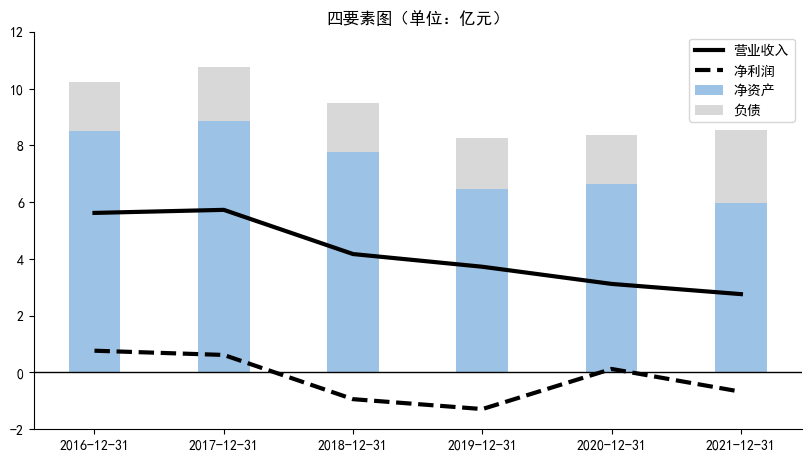

In [58]:
# 四要素图
dataset, title = zoom(TheSheet.loc[:, ['资产总计', '所有者权益合计', '负债合计', '营业总收入', '净利润']])

fig, ax = plt.subplots(figsize=(8, 4.5), layout='constrained')

ax.bar(x, dataset.loc[:, '所有者权益合计'], barwidth, label='净资产', color=cm)
ax.bar(x, dataset.loc[:, '负债合计'], barwidth, dataset.loc[:, '所有者权益合计'], label='负债', color=gray)
ax.plot(x, dataset.loc[:, '营业总收入'], label='营业收入', color=black)
ax.plot(x, dataset.loc[:, '净利润'], label='净利润', color=black, linestyle='--')

ax.set_title('四要素图' + title)

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.axhline(0, color='black', linewidth=1)

ax.legend() # Add a legend.

fig.savefig('1-1.png')

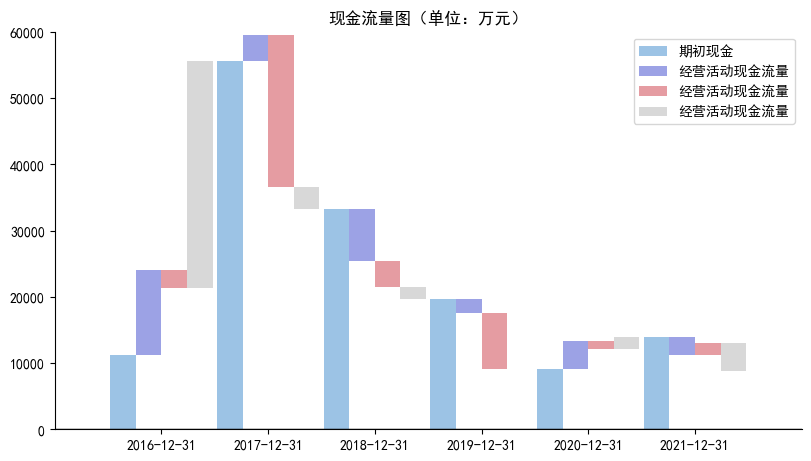

In [92]:
# 现金流量图
dataset, title = zoom(TheSheet.loc[:, ['期初现金及现金等价物余额', '经营活动产生的现金流量净额', '投资活动产生的现金流量净额', '筹资活动产生的现金流量净额']])
a, b, c, d = dataset.loc[:, '期初现金及现金等价物余额'], dataset.loc[:, '经营活动产生的现金流量净额'], dataset.loc[:, '投资活动产生的现金流量净额'], dataset.loc[:, '筹资活动产生的现金流量净额']

width = 0.24

fig, ax = plt.subplots(figsize=(8, 4.5), layout='constrained')

ax.bar(x_coor - width/2*3, a, width, label='期初现金', color=cm)
ax.bar(x_coor - width/2, b, width, a, label='经营活动现金流量', color=cn1)
ax.bar(x_coor + width/2, c, width, a + b, label='经营活动现金流量', color=cn2)
ax.bar(x_coor + width/2*3, d, width, a + b + c, label='经营活动现金流量', color=gray)

ax.set_title('现金流量图' + title)

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.axhline(0, color='black', linewidth=1)

ax.set_xticks(x_coor, x)

ax.legend() # Add a legend.

fig.savefig('1-2.png')

### 3.2.    偿债能力

#### 偿债能力总览

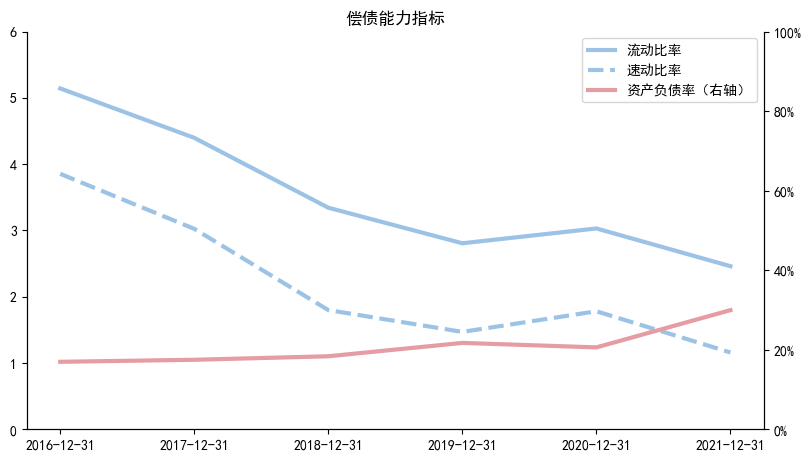

In [93]:
# 流&速动比率与资产负债率
dataset, title = zoom(TheSheet.loc[:, ['流动资产合计', '流动负债合计', '存货净额', '负债合计', '资产总计']])

fig, ax1 = plt.subplots(figsize=(8, 4.5), layout='constrained')
ax2 = ax1.twinx()

cr = dataset.loc[:, '流动资产合计'] / dataset.loc[:, '流动负债合计']
qr = (dataset.loc[:, '流动资产合计'] - dataset.loc[:, '存货净额'])/ dataset.loc[:, '流动负债合计']
lev = dataset.loc[:, '负债合计'] / dataset.loc[:, '资产总计'] * 100

line11, = ax1.plot(x, cr, color=cm)
line12, = ax1.plot(x, qr, color=cm, linestyle='--')
line21, = ax2.plot(x, lev, color=cn2,)

ax2.set_ylim(0, 100)
fmt = '%.0f%%'
yticks = mtick.FormatStrFormatter(fmt)
ax2.yaxis.set_major_formatter(yticks)

ax1.spines['top'].set_color('none')
ax2.spines['top'].set_color('none')

plt.title("偿债能力指标")
plt.legend((line11, line12, line21), ('流动比率', '速动比率', '资产负债率（右轴）')) # Add a legend.

fig.savefig('2-1.png')


#### 债务的期限结构

In [94]:
# 现金和债务规模
dataset, title = zoom(TheSheet.loc[:, ['货币资金', '短期借款', '一年内到期的非流动负债', '应付利息', '应付股利', '流动负债合计', '长期借款', '应付债券', '非流动负债合计']])

cash = dataset.loc[:, '货币资金']

# 短期金融负债
sfd = dataset.loc[:, '短期借款'] + dataset.loc[:, '一年内到期的非流动负债'] + dataset.loc[:, '应付利息'] + dataset.loc[:, '应付股利'] 
# 短期经营负债
sbd = dataset.loc[:, '流动负债合计'] - sfd

# 长期金融负债
lfd = dataset.loc[:, '长期借款'] + dataset.loc[:, '应付债券']
# 长期经营负债
lbd = dataset.loc[:, '非流动负债合计'] - lfd

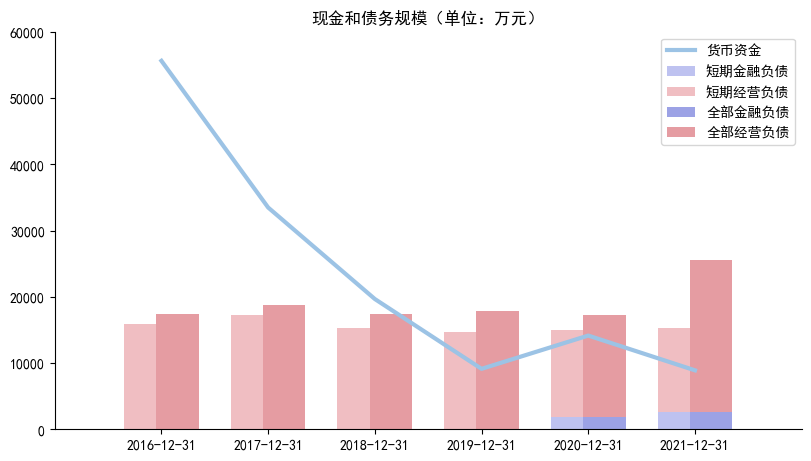

In [95]:
fig, ax = plt.subplots(figsize=(8, 4.5), layout='constrained')
width = 0.3

cn1l = lightcolor(cn1)[0]
cn2l = lightcolor(cn2)[0]

ax.bar(x_coor - width/2, sfd, barwidth, color=cn1l, label='短期金融负债')
ax.bar(x_coor - width/2, sbd, barwidth, color=cn2l, label='短期经营负债', bottom=sfd)
ax.bar(x_coor + width/2, sfd + lfd, barwidth, color=cn1, label='全部金融负债')
ax.bar(x_coor + width/2, sbd + lbd, barwidth, color=cn2, label='全部经营负债', bottom=sfd + lfd)
ax.plot(x_coor, cash, color=cm, lw=3, label='货币资金')

ax.set_xticks(x_coor, x)

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')

plt.title('现金和债务规模' + title)
ax.legend()

fig.savefig('2-2.png')

### 3.3.    盈利能力

In [96]:
dataset, title = zoom(TheSheet.loc[:, ['营业总收入', '营业成本', '净利润']])

ti = dataset.loc[:, '营业总收入']
gp = ti - dataset.loc[:, '营业成本']   # 毛利润
np = dataset.loc[:, '净利润']

gpr = gp / ti * 100   # 毛利率
npr = np / ti * 100  # 净利率

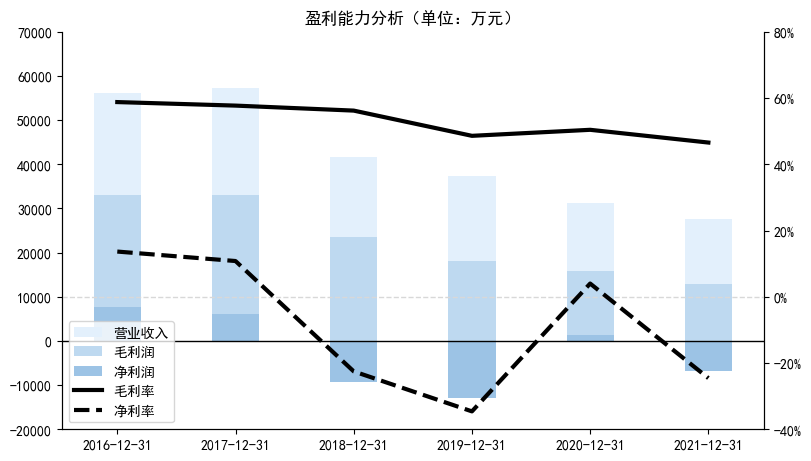

In [97]:
fig, ax1 = plt.subplots(figsize=(8, 4.5), layout='constrained')
ax2 = ax1.twinx()

b_ti = ax1.bar(x, ti, width=0.4, color=cm_l2)
b_gp = ax1.bar(x, gp, width=0.4, color=cm_l1)
b_np = ax1.bar(x, np, width=0.4, color=cm)
ax1.axhline(0, color=black, lw=1)
ax2.axhline(0, color=gray, lw=1, ls='--')

fmt = '%.0f%%'
yticks = mtick.FormatStrFormatter(fmt)
ax2.yaxis.set_major_formatter(yticks)

l_gpr, = ax2.plot(x, gpr, color=black, lw=3)
l_npr, = ax2.plot(x, npr, color=black, lw=3, ls='--')

ax1.spines['top'].set_color('none')
ax2.spines['top'].set_color('none')
plt.title('盈利能力分析' + title)
plt.legend((b_ti, b_gp, b_np, l_gpr, l_npr), ('营业收入', '毛利润', '净利润', '毛利率', '净利率')) # Add a legend.

fig.savefig('3-1.png')

### 3.4.    周转能力/营运能力

In [98]:
dataset, title = zoom(TheSheet.loc[:, ['营业总收入', '应收账款净额', '应收票据净额', '应收款项融资', '合同资产', '营业成本', '存货净额', '预收款项', '合同负债', '应付票据', '应付账款', '预付款项净额']])

# 应收账款
rtr = dataset.loc[1:, '营业总收入'] / (dataset.loc[:, '应收账款净额'] + dataset.loc[:, '应收票据净额'] + dataset.loc[:, '应收款项融资'] + dataset.loc[:, '合同资产']).rolling(2).mean()[1:]
rtd = 360 / rtr

# 存货
itr = dataset.loc[1:, '营业成本'] / dataset.loc[:, '存货净额'].rolling(2).mean()[1:]  # 存货周转率
itd = 360 / itr # 存货周转天数

# 占用客户资金（被占用以'-'号填列）：预收 - 应收
occ = (dataset.loc[:, '预收款项'] + dataset.loc[:, '合同负债']) - (dataset.loc[:, '应收账款净额'] + dataset.loc[:, '应收票据净额'] + dataset.loc[:, '应收款项融资'] + dataset.loc[:, '合同资产'])
# 占用供应商资金（被占用以'-'号填列）：应付 - 预付
osc = (dataset.loc[:, '应付票据'] + dataset.loc[:, '应付账款']) - dataset.loc[:, '预付款项净额']

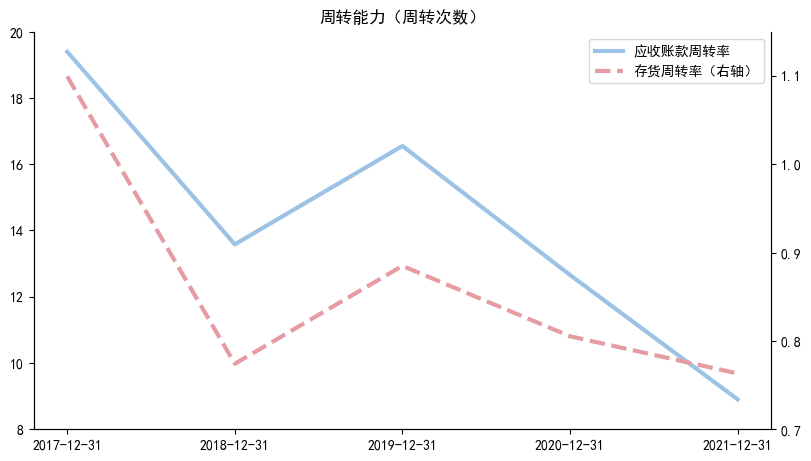

In [99]:
# 周转率
fig, ax1 = plt.subplots(figsize=(8, 4.5), layout='constrained')
ax2 = ax1.twinx()
l_rtr, = ax1.plot(x[1:], rtr, cm)
l_itr, = ax2.plot(x[1:], itr, cn2, linestyle='--')

ax1.spines['top'].set_color('none')
ax2.spines['top'].set_color('none')

plt.title("周转能力（周转次数）")
plt.legend((l_rtr, l_itr), ('应收账款周转率', '存货周转率（右轴）')) # Add a legend.

fig.savefig('4-1.png')

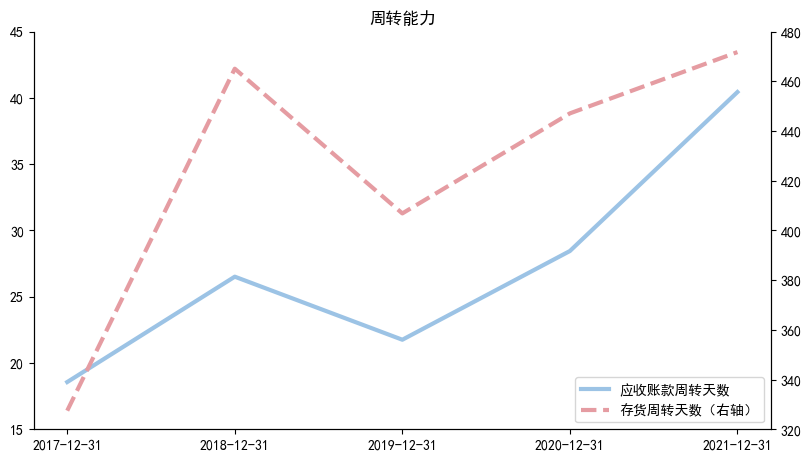

In [100]:
# 周转天数
fig, ax1 = plt.subplots(figsize=(8, 4.5), layout='constrained')
ax2 = ax1.twinx()
l_rtr, = ax1.plot(x[1:], rtd, cm)
l_itr, = ax2.plot(x[1:], itd, cn2, linestyle='--')

ax1.spines['top'].set_color('none')
ax2.spines['top'].set_color('none')

plt.title("周转能力")
plt.legend((l_rtr, l_itr), ('应收账款周转天数', '存货周转天数（右轴）')) # Add a legend.

fig.savefig('4-2.png')

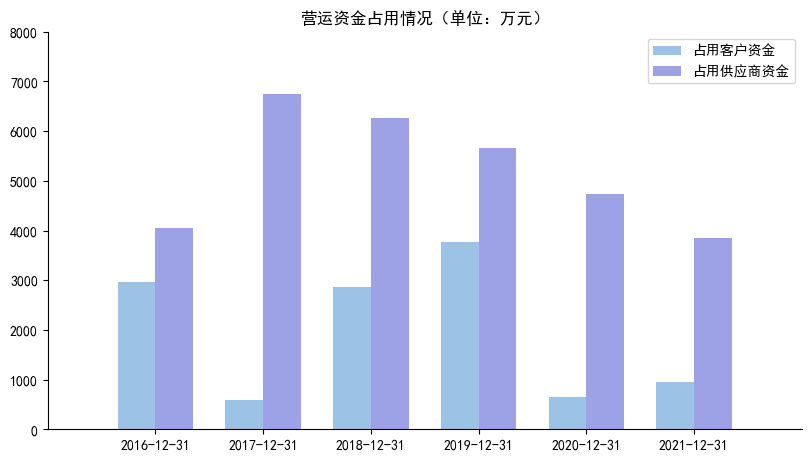

In [101]:
fig, ax = plt.subplots(figsize=(8, 4.5), layout='constrained')

width = 0.35

ax.bar(x_coor - width/2, occ, color=cm, width=width, label='占用客户资金')
ax.bar(x_coor + width/2, osc, color=cn1, width=width, label='占用供应商资金')

ax.set_xticks(x_coor, x)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')

plt.title('营运资金占用情况' + title)
ax.legend()

fig.savefig('4-3.png')